# MINI Tutorial

**Goal:** discover interpretable latents in high-dimensional neural data.

MINI trains sparse autoencoder models whose hidden layer neurons ideally represent interpretable features. This particular LVM approach has had many successes in the field of AI mechanistic interpretability.

We consider a feature’s interpretability in two key aspects: 
1. its correspondence to a specific external variable – a "natural" behavioral or environmental feature
2. its explicit composition from contributing neural activity.

**MINI pipeline:**

1. Load and prepare data
    - Spike data (in the form of binned spike counts as $[examples \times neurons]$)
    - Behavioral and/or environmental (meta)data

2. Train SAEs 
    - Train them to reconstruct the neural data (in this case, from the MC Maze dataset)
    - Validate the quality of the SAE by looking at the sparsity of the SAE features and reconstruction quality of the neural data

3. Save or load the SAE activations

4. Find features
    - Automatically map features to metadata
    - Find meaningful features and their associated biological neurons (referred to as units) using an interactive dashboard
        - The mapping is a starting point to guide the search
        - Or the user can also choose to look through features manually

___

## Setup

**Environment setup:**

Prerequisites:
- An installed version of [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html)
- An installed version of [pixi](https://pixi.sh/latest/)

In the repo's root directory, run `pixi install --manifest-path ./pyproject.toml` - this will create an environment in a newly created `.pixi\envs` folder. Then run `pixi run python -m ipykernel install --user` to be able to use the environment as a kernel to run this notebook.

**Data download:**

In this tutorial we will be using the churchland_shenoy_neural_2012 dataset from [brainsets](https://brainsets.readthedocs.io/en/latest/glossary/brainsets.html#churchland-shenoy-neural-2012) (also known as MC_Maze). Once your environment is installed, follow the instructions to configure your data directories for brainsets [here](https://brainsets.readthedocs.io/en/latest/concepts/using_existing_data.html#configuring-data-directories). Then run `brainsets prepare churchland_shenoy_neural_2012`. When your data has finished downloading, go ahead and start the tutorial below!

In [1]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2

In [ ]:
"""Import packages."""

# Standard library
from datetime import datetime
from pathlib import Path

# IPython/Jupyter
from IPython.display import display

# Third-party
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t
from einops import asnumpy, reduce
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

# Local project modules
from mini import train as mt
from mini import mc_maze
from mini.train_val_split import train_val_split_by_proportion, train_val_split_by_session
from mini import pipeline

# 1. Load and prepare data

In the churchland_shenoy_neural_2012 dataset, the subjects are performing a center-out reaching task on a variety of different maze configurations. Each maze configuration comes in 3 versions:
- 1 target and no barriers.
- 1 target with barriers.
- 3 targets, with barriers. But 2 of the targets are distractors and unaccessible given the barrier configuration.

So maze conditions 1, 2, 3 are related; as are maze conditions 4, 5, 6; and so on.
Neural activity was recorded from the dorsal premotor (PMd) and primary motor (M1) cortices. A variety of other data (monkey hand position, velocity and acceleration, gaze position...) is also provided.

## Load and prepare spike data

In [ ]:
data_path = Path(r"path\to\brainsets\processed\churchland_shenoy_neural_2012")
data_path = Path(r"C:\Users\pouge\Documents\mini_data\brainsets\processed\churchland_shenoy_neural_2012") # TODO: delete this
subject_name = "jenkins"  # or "nitschke"

# Load
sessions = mc_maze.load_sessions(data_path, subject_name)


Loading file 1/4: jenkins_20090912_center_out_reaching.h5
Session ID: jenkins_20090912_center_out_reaching
Session subject id: jenkins
Session subject sex: MALE
Session subject species: MACACA_MULATTA
Session recording date: 2009-09-12 00:00:00
Original number of trials: 1588
Cleaning data...
Final number of trials after cleaning: 1015

Loading file 2/4: jenkins_20090916_center_out_reaching.h5
Session ID: jenkins_20090916_center_out_reaching
Session subject id: jenkins
Session subject sex: MALE
Session subject species: MACACA_MULATTA
Session recording date: 2009-09-16 00:00:00
Original number of trials: 2265
Cleaning data...
Final number of trials after cleaning: 1379

Loading file 3/4: jenkins_20090918_center_out_reaching.h5
Session ID: jenkins_20090918_center_out_reaching
Session subject id: jenkins
Session subject sex: MALE
Session subject species: MACACA_MULATTA
Session recording date: 2009-09-18 00:00:00
Original number of trials: 2636
Cleaning data...
Final number of trials afte

,Maze Condition,Trials,Barriers,Targets,Hit Position,Hit Position Angles
0,1,20,[0],[1],"[111, 85]",37.443657
1,2,16,[6],[1],"[111, 85]",37.443657
2,3,19,[6],[3],"[111, 85]",37.443657
3,4,21,[0],[1],"[133, -80]",-31.027065
4,5,22,[6],[1],"[133, -80]",-31.027065
...,...,...,...,...,...,...
103,104,22,[9],[1],"[2, 82]",88.60281
104,105,19,[9],[3],"[2, 82]",88.60281
105,106,20,[0],[1],"[-109, 2]",178.94882
106,107,21,[9],[1],"[-109, 2]",178.94882



List of maze conditions present in each session:
Session jenkins_20090912_center_out_reaching: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 37, 38, 39, 40, 41, 42, 43, 44, 45]
Session jenkins_20090916_center_out_reaching: [19, 20, 21, 22, 23, 24, 25, 26, 27, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
Session jenkins_20090918_center_out_reaching: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
Session jenkins_20090923_center_out_reaching: [73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [5]:
"""Bin spike data."""

bin_size = 0.05 # in sevars
spikes_df = mc_maze.bin_spike_data(sessions, bin_size) # this can take several minutes

display(spikes_df)

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
timestamp,,,,,,,,,,,,,,,,,,,,,
1.252710e+09,0,1,5,2,3,0,3,2,3,2,...,3,1,0,5,2,2,2,1,3,0
1.252710e+09,0,0,2,0,3,0,1,1,3,3,...,0,1,1,0,4,3,1,3,3,1
1.252710e+09,1,0,1,0,1,0,0,0,3,3,...,2,0,0,0,0,1,2,0,0,3
1.252710e+09,0,2,2,0,3,0,2,0,2,2,...,1,1,2,0,0,2,1,1,3,0
1.252710e+09,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.253673e+09,0,1,0,1,2,0,2,0,3,7,...,2,9,1,0,7,3,3,4,2,5
1.253673e+09,0,0,1,0,2,0,1,1,4,4,...,7,5,1,3,5,5,2,5,5,8
1.253673e+09,0,2,0,1,1,1,1,1,4,4,...,4,2,0,1,3,2,3,3,6,5


Firing rates distribution:


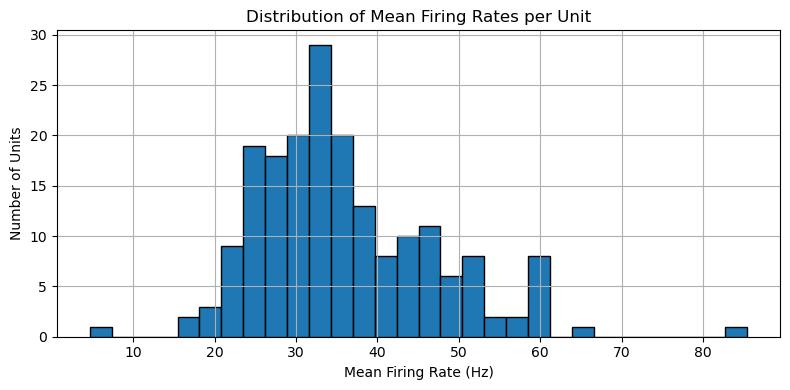

Mean: 36.14 Hz
Range: 4.66–85.44 Hz


Spike count distribution and sparsity stats:


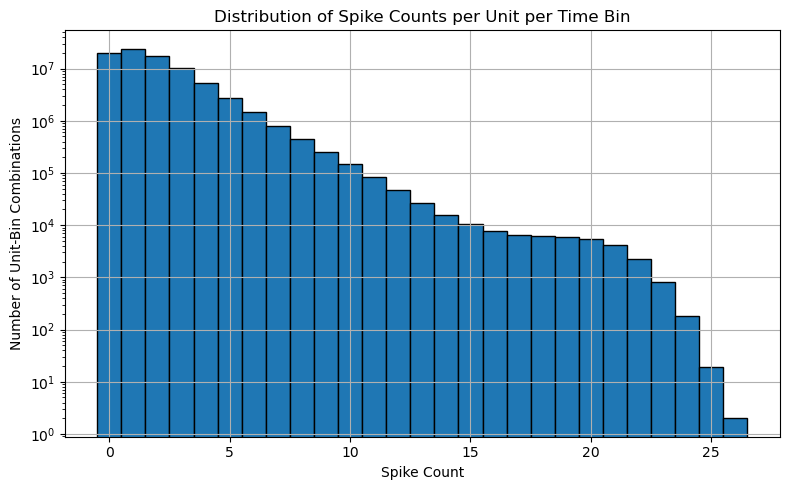

Fraction of non-zero bins: 0.7637
Fraction of non-zero examples: 1.0000


In [6]:
"""Quick plots and stats to get a sense of the spike data."""

print("Firing rates distribution:")
# Compute mean firing rate (Hz) per unit
duration_sec = len(spikes_df) * bin_size
mean_firing_rates = spikes_df.sum(axis=0) / duration_sec  # spikes_arr/sec
# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(mean_firing_rates, bins=30, edgecolor='black')
plt.xlabel('Mean Firing Rate (Hz)')
plt.ylabel('Number of Units')
plt.title('Distribution of Mean Firing Rates per Unit')
plt.grid(True)
plt.tight_layout()
plt.show()
# Print stats
print("Mean: {:.2f} Hz".format(mean_firing_rates.mean()))
print("Range: {:.2f}–{:.2f} Hz".format(mean_firing_rates.min(), mean_firing_rates.max()))

print("\n\nSpike count distribution and sparsity stats:")
# Flatten spike counts
flattened_spike_counts = spikes_df.values.flatten()
# Define bins that align exactly to integer spike counts
max_count = flattened_spike_counts.max()
bins = np.arange(0, max_count + 2) - 0.5  # centers bins on integers
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(flattened_spike_counts, bins=bins, edgecolor='black')
plt.title("Distribution of Spike Counts per Unit per Time Bin")
plt.xlabel("Spike Count")
plt.ylabel("Number of Unit-Bin Combinations")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()
# Print stats
frac_nonzero_bins = (spikes_df != 0).values.sum() / spikes_df.size
frac_nonzero_examples = (spikes_df.sum(axis=1) > 0).mean()
print(f"Fraction of non-zero bins: {frac_nonzero_bins:.4f}")
print(f"Fraction of non-zero examples: {frac_nonzero_examples:.4f}")


## Load and prepare environment / behavior (meta)data

In [7]:
# Retrieve and collate metadata (hand/eye/events) across sessions
metadata, trials_df = mc_maze.retrieve_metadata(sessions) # this can take a minute
# Bin metadata to the match the binned spikes_df
metadata_binned = mc_maze.bin_metadata(metadata, trials_df, bin_size, spikes_df.index)

print("Metadata:")
display(metadata)
print("Binned metadata:")
display(metadata_binned)

Metadata:


,acc_x,acc_y,pos_x,pos_y,vel_x,vel_y,session,pos_x_eye,pos_y_eye,event,trial_idx,maze_condition,barriers,targets,hit_position_x,hit_position_y,hit_position_angle,movement_angle,vel_magnitude,accel_magnitude
timestamp,,,,,,,,,,,,,,,,,,,,
1.252710e+09,-318.112010,-349.493909,2.684289,-27.751781,2.029887,-21.176818,0,-6.0,12.9,NaN,0.0,10,0,1,132,46,19.212671,NaN,21.273883,472.589931
1.252710e+09,-402.998304,-558.682011,2.686319,-27.772957,1.711775,-21.526312,0,-6.4,11.0,NaN,0.0,10,0,1,132,46,19.212671,-84.524687,21.594265,688.863718
1.252710e+09,-430.359657,-769.504367,2.687712,-27.794833,1.223890,-22.294182,0,-7.0,13.1,NaN,0.0,10,0,1,132,46,19.212671,-86.354729,22.327751,881.672504
1.252710e+09,-395.382562,-689.557801,2.688767,-27.817546,0.851056,-23.065321,0,-7.1,11.1,NaN,0.0,10,0,1,132,46,19.212671,-87.342739,23.081017,794.869380
1.252710e+09,-416.602764,-522.552280,2.689415,-27.840964,0.433125,-23.673298,0,-7.0,9.5,NaN,0.0,10,0,1,132,46,19.212671,-88.414993,23.677260,668.295405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.253673e+09,770.400653,606.850279,-101.669442,-104.262970,-1.542859,3.392633,3,-108.4,-90.8,NaN,6128.0,90,7,3,-105,-76,-144.102615,121.522071,3.726979,980.706086
1.253673e+09,723.056654,569.509874,-101.670618,-104.259298,-0.803108,3.970243,3,-108.5,-90.8,NaN,6128.0,90,7,3,-105,-76,-144.102615,107.758984,4.050656,920.408834
1.253673e+09,710.002878,483.201604,-101.671048,-104.255029,-0.096746,4.531652,3,-109.2,-91.1,NaN,6128.0,90,7,3,-105,-76,-144.102615,95.756709,4.532685,858.829364


Binned metadata:


,acc_x,acc_y,pos_x,pos_y,vel_x,vel_y,session,pos_x_eye,pos_y_eye,maze_condition,barriers,targets,hit_position_x,hit_position_y,hit_position_angle,movement_angle,vel_magnitude,accel_magnitude,event,trial_idx
timestamp,,,,,,,,,,,,,,,,,,,,
1.252710e+09,-318.112010,-349.493909,2.684289,-27.751781,2.029887,-21.176818,0,-6.0,12.9,10,0,1,132,46,19.212671,NaN,21.273883,472.589931,start,0.0
1.252710e+09,-497.464127,-632.636229,2.852594,-28.756098,1.907928,-21.723573,0,-7.1,11.7,10,0,1,132,46,19.212671,-84.175049,21.807197,804.797587,start -> target_on,0.0
1.252710e+09,376.796978,-127.597097,2.207741,-30.821150,-14.462500,-50.774300,0,-6.0,11.2,10,0,1,132,46,19.212671,-106.032733,52.793877,397.815261,start -> target_on,0.0
1.252710e+09,-284.046162,-209.016365,1.936817,-32.045630,-0.525935,-5.951463,0,-7.6,11.0,10,0,1,132,46,19.212671,-93.717577,5.974656,352.661400,start -> target_on,0.0
1.252710e+09,-89.561862,160.722499,1.807268,-32.479916,-8.481216,-7.023836,0,-6.1,12.1,10,0,1,132,46,19.212671,-139.387473,11.012053,183.991981,start -> target_on,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.253673e+09,380.000362,142.529899,-101.669815,-104.245156,0.996898,5.079176,3,-108.5,-91.0,90,7,3,-105,-76,-144.102615,78.895617,5.176083,405.851016,move_ends -> end,6128.0
1.253673e+09,380.000362,142.529899,-101.669815,-104.245156,0.996898,5.079176,3,-108.5,-91.0,90,7,3,-105,-76,-144.102615,78.895617,5.176083,405.851016,move_ends -> end,6128.0
1.253673e+09,380.000362,142.529899,-101.669815,-104.245156,0.996898,5.079176,3,-108.5,-91.0,90,7,3,-105,-76,-144.102615,78.895617,5.176083,405.851016,move_ends -> end,6128.0


## Train/val split

In [10]:
"""Train/val split, smooth and normalize spikes."""

split_by_session = False # if False, will split by proportion

if split_by_session:
    train_trials, val_trials = train_val_split_by_session(
        metadata_binned["trial_idx"].to_numpy(),
        metadata_binned["session"].to_numpy(),
        train_sessions=[0, 1, 2],  # pick your training sessions
        shuffle=True,
        seed=0,
    )
else:
    train_trials, val_trials = train_val_split_by_proportion(
        metadata_binned["trial_idx"].values,
        train_proportion=0.8,
        shuffle=True,
        seed=0,
    )

# Create boolean masks to split metadata and spikes into train/val sets
train_mask = metadata_binned['trial_idx'].isin(train_trials)
val_mask = metadata_binned['trial_idx'].isin(val_trials)

# Split metadata
metadata_binned_train = metadata_binned[train_mask].reset_index(drop=True)
metadata_binned_val = metadata_binned[val_mask].reset_index(drop=True)

# Split spikes 
spikes_arr = spikes_df.values.astype(np.float32)
spikes_train_arr = spikes_arr[train_mask]
spikes_val_arr = spikes_arr[val_mask]

# Smooth spikes
sigma = 0.05 / bin_size
spikes_train_arr = gaussian_filter1d(spikes_train_arr, sigma=sigma, axis=0)
spikes_val_arr = gaussian_filter1d(spikes_val_arr, sigma=sigma, axis=0)

# Normalize spikes (fit normalization on training data only)
train_max = spikes_train_arr.max()
spikes_train_arr = spikes_train_arr / train_max
spikes_val_arr = spikes_val_arr / train_max

# Summary
print(f"Train set: {len(train_trials)} trials ({train_mask.sum()} time bins)")
print(f"Val set: {len(val_trials)} trials ({val_mask.sum()} time bins)")
print(f"Spike data shapes: train {spikes_train_arr.shape}, val {spikes_val_arr.shape}")

Train set: 4903 trials (347788 time bins)
Val set: 1226 trials (86664 time bins)
Spike data shapes: train (347788, 191), val (86664, 191)


In [11]:
"""Convert to torch tensors and move to device."""

# it's best to have a gpu for training!
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")

spikes_train = t.from_numpy(spikes_train_arr).to(device).to(dtype=t.bfloat16)
spikes_val = t.from_numpy(spikes_val_arr).to(device).to(dtype=t.bfloat16)

display(spikes_train)
display(spikes_val)

device=device(type='cuda')


tensor([[2.4872e-03, 2.7710e-02, 1.6504e-01,  ..., 6.5430e-02, 1.2061e-01,
         2.0142e-02],
        [1.0315e-02, 1.7212e-02, 1.1279e-01,  ..., 6.6895e-02, 9.6680e-02,
         4.8340e-02],
        [1.7212e-02, 2.3193e-02, 7.3242e-02,  ..., 4.8584e-02, 6.9336e-02,
         6.2012e-02],
        ...,
        [0.0000e+00, 4.6631e-02, 1.0742e-02,  ..., 1.5918e-01, 1.8945e-01,
         2.2656e-01],
        [0.0000e+00, 3.8086e-02, 2.3193e-03,  ..., 1.3770e-01, 1.5918e-01,
         1.6504e-01],
        [0.0000e+00, 1.7578e-02, 1.9455e-04,  ..., 1.1377e-01, 1.5039e-01,
         1.1914e-01]], device='cuda:0', dtype=torch.bfloat16)

tensor([[0.0153, 0.0004, 0.0505,  ..., 0.0457, 0.0405, 0.0325],
        [0.0299, 0.0046, 0.1060,  ..., 0.0581, 0.0649, 0.0361],
        [0.0376, 0.0206, 0.1289,  ..., 0.0874, 0.0659, 0.0540],
        ...,
        [0.0000, 0.1592, 0.0206,  ..., 0.3066, 0.1729, 0.1621],
        [0.0000, 0.1235, 0.0195,  ..., 0.2432, 0.1201, 0.1494],
        [0.0000, 0.0781, 0.0128,  ..., 0.1943, 0.1309, 0.1641]],
       device='cuda:0', dtype=torch.bfloat16)

# 2. Train SAEs

This code trains 2 Matryoshka SAEs with identical setups so that you can compare the different instances and ensure they both give similar results. For each time bin of neural data in the train and val sets, the SAEs' hidden-layer activations are calculated, and it is these activations that will be used to find a feature's correspondance with external variables.

If desired, you can choose to skip this section and load pre-saved activations instead. A set of activations per subject (Jenkins and Nitschke) is provided - go to section "3. Save/load SAE activations" for more information.

TODO: EXPLAIN WHAT PARAMETERS TO PLAY WITH AND WHAT THE MATRYOSHKA SETUP IS?

## Train SAEs

In [12]:
"""Set config."""

dsae_topk_map = {256: 8, 512: 16, 1024: 24}
dsae_topk_map = dict(sorted(dsae_topk_map.items()))  # ensure sorted from smallest to largest
dsae_loss_x_map = {256: 1, 512: 1.25, 1024: 1.5}
dsae_loss_x_map = dict(sorted(dsae_loss_x_map.items()))
dsae = max(dsae_topk_map.keys())
n_inst = 2

In [13]:
"""Train model."""

sae_cfg = mt.SaeConfig(
    n_input_ae=spikes_train.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = (spikes_train.shape[0] // batch_sz) * n_epochs
log_freq = max(1, n_steps // n_epochs // 2)
dead_neuron_window = max(1, n_steps // n_epochs // 3)

data_log = mt.optimize(  # train model
    spk_cts=spikes_train,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau,
)

SAE batch training step: 100%|██████████| 6780/6780 [03:20<00:00, 33.79it/s, loss=0.00240,  l0_mean=24.0, l0_std=7.966527462005615, frac_dead=0.88916015625] 


## Validate SAEs

In [14]:
"""Check for nans in weights."""

sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

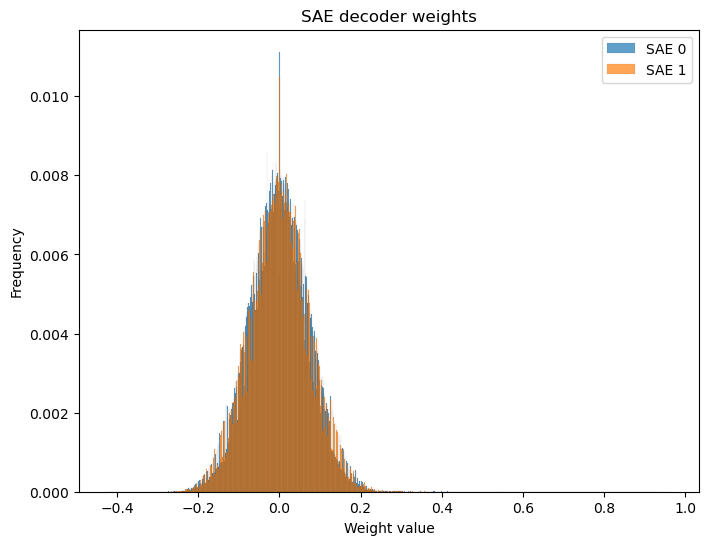

In [15]:
"""Visualize weights."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

SAE batch evaluation step: 100%|██████████| 339/339 [00:03<00:00, 92.35it/s] 
c:\Users\pouge\Documents\mini\.pixi\envs\default\lib\site-packages\IPython\core\events.py:82: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



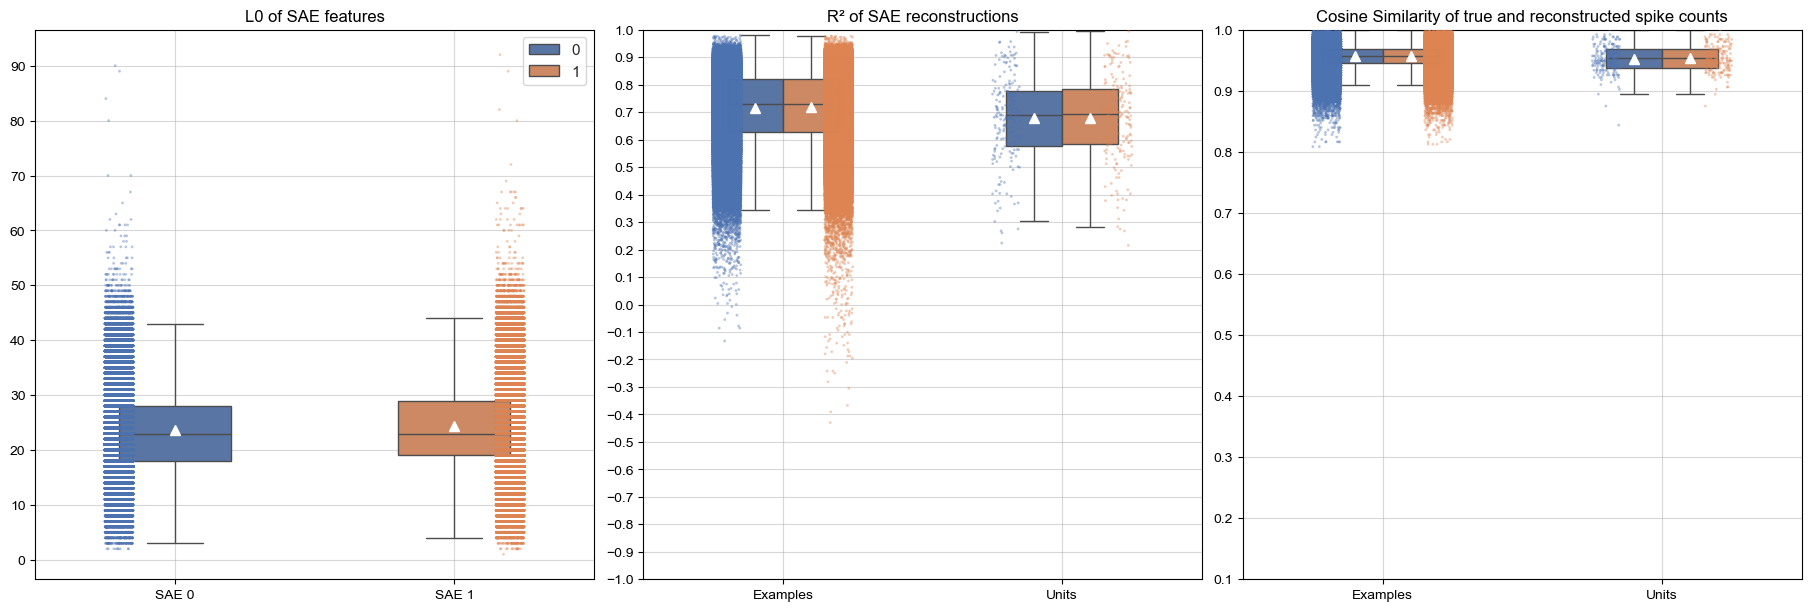

In [16]:
"""Visualize metrics over all examples and units."""

topk_acts_4d_train, recon_spk_cts_train, r2_per_unit_train, _, cossim_per_unit_train, _ = mt.eval_model(
    spikes_train, sae, batch_sz=batch_sz
)

In [19]:
"""Calculate variance explained of summed spike counts."""

n_recon_examples = recon_spk_cts_train.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts_train, "example inst unit -> example inst", "sum")

actual_summed_spk_cts = reduce(spikes_train, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[:n_recon_examples]  # trim to match

for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()),
        asnumpy(recon_summed_spk_cts[:, inst].float()),
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")


SAE instance 0 R² (summed spike count over all units per example) = 0.998
SAE instance 1 R² (summed spike count over all units per example) = 0.998


## Remove bad units and retrain

In [20]:
"""Remove bad units and retrain."""

# Set threshold for removing units
r2_thresh = 0.1
inst = 0
r2_inst = r2_per_unit_train[:, inst]
keep_mask = r2_inst > r2_thresh
print(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")
print(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")

if keep_mask.all():
    print("All units pass threshold — skipping retrain.")
    spikes_train_pruned = spikes_train
    spikes_val_pruned = spikes_val
else:
    # Prune
    spikes_train_pruned = spikes_train[:, keep_mask]
    spikes_val_pruned = spikes_val[:, keep_mask]

    # Retrain SAE on pruned train data
    sae_cfg = mt.SaeConfig(
        n_input_ae=spikes_train_pruned.shape[1],
        dsae_topk_map=dsae_topk_map,
        dsae_loss_x_map=dsae_loss_x_map,
        seq_len=1,
        n_instances=n_inst,
    )
    sae = mt.Sae(sae_cfg).to(device)
    loss_fn = mt.msle
    tau = 1.0
    lr = 5e-3

    n_epochs = 20
    batch_sz = 1024
    n_steps = (spikes_train_pruned.shape[0] // batch_sz) * n_epochs
    log_freq = max(1, n_steps // n_epochs // 2)
    dead_neuron_window = max(1, n_steps // n_epochs // 3)

    data_log = mt.optimize(
        spk_cts=spikes_train_pruned,
        sae=sae,
        loss_fn=loss_fn,
        optimizer=t.optim.Adam(sae.parameters(), lr=lr),
        use_lr_sched=True,
        dead_neuron_window=dead_neuron_window,
        n_steps=n_steps,
        log_freq=log_freq,
        batch_sz=batch_sz,
        log_wandb=False,
        plot_l0=False,
        tau=tau,
    )

frac units above r2_thresh=0.1: 1.00
Number to keep: 191 / 191
All units pass threshold — skipping retrain.


In [21]:
"""Re-visualize metrics over all examples and units."""

if keep_mask.all():
    print("All units pass threshold — skipping re-visualization.")
else:
    topk_acts_4d_train, recon_spk_cts_train, r2_per_unit_train, _, cossim_per_unit_train, _ = mt.eval_model(
        spikes_train_pruned, sae, batch_sz=batch_sz
    )

    n_recon_examples_train = recon_spk_cts_train.shape[0]
    recon_summed_train = reduce(recon_spk_cts_train, "example inst unit -> example inst", "sum")

    actual_summed_train = reduce(spikes_train_pruned, "example unit -> example", "sum")
    actual_summed_train = actual_summed_train[:n_recon_examples_train]

    for inst in range(n_inst):
        r2 = r2_score(
            asnumpy(actual_summed_train.float()),
            asnumpy(recon_summed_train[:, inst].float()),
        )
        print(f"SAE instance {inst} R² (summed spike count per example) = {r2:.3f}")

All units pass threshold — skipping re-visualization.


Validation data metrics:


SAE batch evaluation step: 100%|██████████| 84/84 [00:01<00:00, 69.36it/s]


SAE instance 0 R² (summed spike count per example) = 0.998
SAE instance 1 R² (summed spike count per example) = 0.997


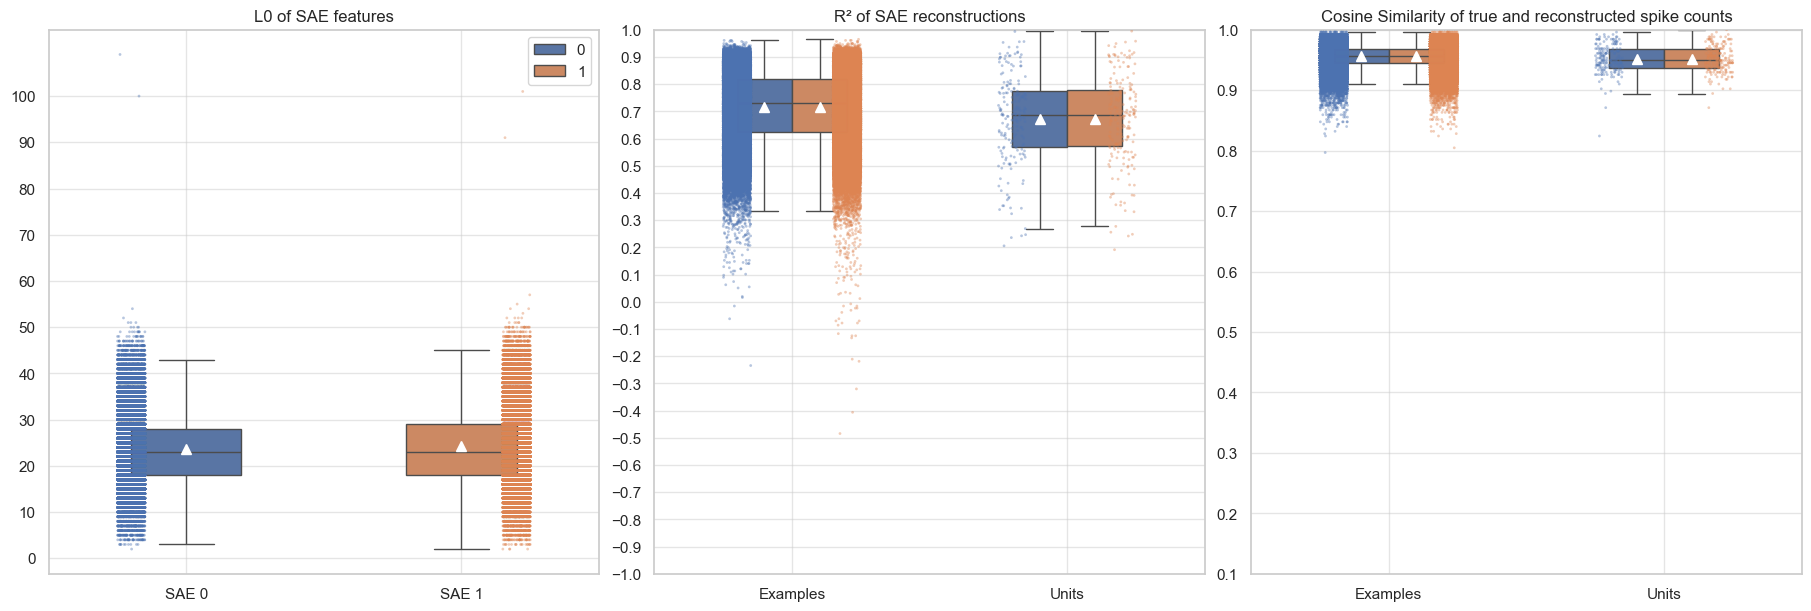

In [22]:
"""Visualize metrics on validation data."""

if spikes_val_pruned.shape[0] == 0:
    print("No validation data available.")
else:
    print("Validation data metrics:")

    topk_acts_4d_val, recon_spk_cts_va, r2_per_unit_va, _, cossim_per_unit_va, _ = mt.eval_model(
        spikes_val_pruned, sae, batch_sz=batch_sz
    )

    n_recon_examples_val = recon_spk_cts_va.shape[0]
    recon_summed_val = reduce(recon_spk_cts_va, "example inst unit -> example inst", "sum")

    actual_summed_val = reduce(spikes_val_pruned, "example unit -> example", "sum")
    actual_summed_val = actual_summed_val[:n_recon_examples_val]

    for inst in range(n_inst):
        r2 = r2_score(
            asnumpy(actual_summed_val.float()),
            asnumpy(recon_summed_val[:, inst].float()),
        )
        print(f"SAE instance {inst} R² (summed spike count per example) = {r2:.3f}")

# 3. Save/load SAE activations

A set of activations per subject (Jenkins and Nitschke) is provided in the `trained_saes` folder. They were both generated using a split by proportion (80/20 train/val split). If you want to use them, move the subfolders within `trained_saes` to the path you specified as the `data_path` at the beginning of this notebook and switch the load_activations option below to "True".

In [ ]:
"""Load saved activations (Etr/Eval) if available; otherwise (only if save_activations=True) densify from top-k and save."""

load_activations = False
save_activations = True
activations_file_train = "sae_activations_train.csv"
activations_file_val = "sae_activations_val.csv"
mask_file_train = "train_mask.csv"
mask_file_val = "val_mask.csv"

# Build save path (same style as before)
session_dates = []
for session in sessions:
    session_date = datetime.fromtimestamp(session.session.recording_date).strftime("%Y%m%d")
    session_dates.append(session_date)
session_dates_str = "_".join(session_dates)

activations_save_path = data_path / f"{subject_name}_{session_dates_str}" / "sae_activations"
activations_save_path.mkdir(parents=True, exist_ok=True)

if load_activations:
    acts_df_train = pd.read_csv(
        activations_save_path / activations_file_train,
        dtype={"example_idx": int, "instance_idx": int, "feature_idx": int, "activation_value": np.float32}
    )
    acts_df_val = pd.read_csv(
        activations_save_path / activations_file_val,
        dtype={"example_idx": int, "instance_idx": int, "feature_idx": int, "activation_value": np.float32}
    )
    train_mask = pd.read_csv(activations_save_path / mask_file_train, dtype=bool)
    val_mask = pd.read_csv(activations_save_path / mask_file_val, dtype=bool)
    print(f"Loaded activations from {activations_save_path}")
else:
    # Build Etr/Eval from top-k activations (sparse → dense)
    # Train
    arr_tr = asnumpy(topk_acts_4d_train)  # [example_idx, instance_idx, feature_idx, activation_value]
    # Sparse activations (tight dtypes on indices, fp32 values)
    acts_df_train = pd.DataFrame({
        "example_idx": arr_tr[:, 0].astype(int),
        "instance_idx": arr_tr[:, 1].astype(int),
        "feature_idx": arr_tr[:, 2].astype(int),
        "activation_value": arr_tr[:, 3].astype(np.float32),
    })

    if spikes_val_pruned.shape[0] > 0:
        # Val
        arr_va = asnumpy(topk_acts_4d_val)
        acts_df_val = pd.DataFrame({
            "example_idx": arr_va[:, 0].astype(int),
            "instance_idx": arr_va[:, 1].astype(int),
            "feature_idx": arr_va[:, 2].astype(int),
            "activation_value": arr_va[:, 3].astype(np.float32),
        })

    n_examples_train = (int(acts_df_train["example_idx"].max()) + 1)
    std_threshold = 1e-6

    # Precompute squared values once, then sum both in one grouped pass
    acts_df_train_with_sq = acts_df_train.assign(activation_value_sq=acts_df_train["activation_value"] ** 2)

    feature_stats = (
        acts_df_train_with_sq.groupby(["instance_idx", "feature_idx"], as_index=False)
          .agg(sum_val=("activation_value", "sum"),
               sum_sq=("activation_value_sq", "sum"))
    )
    # Population variance which takes into account missing rows where activations are zero
    feature_stats["mean"] = feature_stats["sum_val"] / n_examples_train
    feature_stats["var"]  = (feature_stats["sum_sq"] / n_examples_train) - feature_stats["mean"]**2
    feature_stats["std"]  = np.sqrt(np.clip(feature_stats["var"].to_numpy(), 0.0, None))

    kept_features = feature_stats.loc[feature_stats["std"] > std_threshold, ["instance_idx", "feature_idx"]]
    n_dropped = len(feature_stats) - len(kept_features)

    if n_dropped:
        # Semi-join to keep only surviving (instance, feature) pairs
        acts_df_train = acts_df_train.merge(kept_features, on=["instance_idx", "feature_idx"], how="inner")
        acts_df_val = acts_df_val.merge(kept_features, on=["instance_idx", "feature_idx"], how="inner") if (spikes_val_pruned.shape[0] > 0) else None
        print(f"Pruned {n_dropped} features (std ≤ {std_threshold}). Kept {len(kept_features)}.")

    if save_activations:
        acts_df_train.to_csv(activations_save_path / activations_file_train, index=False)
        acts_df_val.to_csv(activations_save_path / activations_file_val, index=False) if spikes_val_pruned.shape[0] > 0 else None
        train_mask.to_csv(activations_save_path / mask_file_train, index=False)
        val_mask.to_csv(activations_save_path / mask_file_val, index=False)
        print(f"Saved activations to {activations_save_path}")

if spikes_val_pruned.shape[0] > 0:
    print(f"Activations: \nTrain shape: {acts_df_train.shape}, Val shape: {acts_df_val.shape}")
else:
    print(f"Activations: \nTrain shape: {acts_df_train.shape}")

Saved activations to C:\Users\pouge\Documents\mini_data\brainsets\processed\churchland_shenoy_neural_2012\jenkins_20090912_20090916_20090918_20090923\sae_activations
Activations: 
Train shape: (16662528, 4), Val shape: (4128768, 4)


# 4. Find features

## Pick dataset

In [ ]:
"""Pick whether to find features in training or validation set."""

search_train = True

if search_train:
    acts_df_split = acts_df_train
    metadata_binned_split = metadata_binned[train_mask].copy()
    spikes_df_split = spikes_df[train_mask].copy()
else:
    acts_df_split = acts_df_val
    metadata_binned_split = metadata_binned[val_mask].copy()
    spikes_df_split = spikes_df[val_mask].copy()

## Automatically map features to metadata

**How it works:**

Features are mapped to metadata variables through the calculation of a selectivity score. For a feature $f$ and condition $c$ (variable/value combination e.g., velocity is between 0 and 1, or maze condition = 3, etc.):

$$
\text{activation\_frac\_during} =
\frac{\#\{\text{activations of } f \text{ in examples with } c\}}
     {\#\{\text{examples with } c\}}
$$

$$
\text{activation\_frac\_outside} =
\frac{\#\{\text{activations of } f \text{ in examples without } c\}}
     {\#\{\text{examples without } c\}}
$$

$$
\text{selectivity\_score} =
\frac{\text{activation\_frac\_during}}
     {\text{activation\_frac\_during} + \text{activation\_frac\_outside}}
$$

- $\approx 1$: feature mainly active *during* the condition (highly selective)  
- $\approx 0.5$: feature active equally in/out (not selective)  
- $\approx 0$: feature mostly active *outside* the condition

The map_features_to_metadata function:
1. For discrete variables: computes activation fractions + selectivity score per condition value.  
2. For continuous variables: bins, then reuses discrete analysis.  
3. Results are ranked by selectivity score and the `top_n_features` are returned.

**Key arguments to play with:**
- `discrete_vars` and `continuous_vars`: as default only one of each was included because the function takes time to run, but you may be interested in exploring different or additional variables
- `n_bins_continuous`: number of bins for continuous variables. This will affect whether you find more general features (small number of bins so you have less granularity e.g., you can only distinguish between fast vs slow hand velocity) or specific features (larger number of bins for more granularity e.g., you can now distinguish between very fast vs fast vs intermediate vs slow vs very slow hand velocity)
- `min_activation_frac`: minimum fraction of condition examples a feature must activate in
- `top_n_features`: number of highest-scoring features kept per variable/value/instance (default `3`)

In [ ]:
"""Map features to metadata variables."""

# discrete_vars = ['event', 'maze_condition', 'barriers', 'targets', 'hit_position_x', 'hit_position_y', 'hit_position_angle']
# continuous_vars = ['vel_magnitude', 'accel_magnitude', 'movement_angle']
discrete_vars = ['event']
continuous_vars = ['vel_magnitude']
feature_metadata_mapping = pipeline.map_features_to_metadata( # this can take a minute
    acts_df_split, metadata_binned_split,
    discrete_vars=discrete_vars,
    continuous_vars=continuous_vars,
    min_activation_frac=0.5,
    n_bins_continuous=[12],
    top_n_features=3
)
feature_metadata_mapping

Starting automated feature-to-metadata mapping...

Analyzing variable: event...
    Found 138 potential associations

Analyzing variable: vel_magnitude...
    Binning 'vel_magnitude' into 12 bins...
    Found 180 potential associations

Ranking features and selecting top 3 for each variable...

Found 65 top discrete associations
Found 72 top continuous associations
Total: 137 associations returned in single DataFrame


,variable,variable_type,value,instance_idx,feature_idx,activation_frac_during,activation_frac_outside,selectivity_score
0,vel_magnitude,continuous,"(0.00721, 0.951]",0.0,164.0,0.692371,0.543163,0.560382
1,vel_magnitude,continuous,"(0.00721, 0.951]",0.0,129.0,0.595280,0.492724,0.547130
2,vel_magnitude,continuous,"(0.00721, 0.951]",0.0,189.0,0.629231,0.603670,0.510366
3,vel_magnitude,continuous,"(0.00721, 0.951]",1.0,134.0,0.727737,0.579900,0.556528
4,vel_magnitude,continuous,"(0.00721, 0.951]",1.0,14.0,0.564814,0.493587,0.533648
...,...,...,...,...,...,...,...,...
132,event,discrete,target_on -> go_cue,0.0,129.0,0.563988,0.493535,0.533310
133,event,discrete,target_on -> go_cue,0.0,218.0,0.501113,0.449453,0.527173
134,event,discrete,target_on -> go_cue,1.0,134.0,0.681803,0.581171,0.539839
135,event,discrete,target_on -> go_cue,1.0,37.0,0.553696,0.492230,0.529383


## Find meaningful features and their associated  units

The feature metadata mapping df from before is used as a starting point to identify promising features ("preset" option on the dashboard). If you want more preset options to explore, feel free to return to the "Automatically map features to metadata" section and play with the arguments that control the mapping process.


You may also choose to look through features manually, though this tends to take a lot of time ("manual selection" option on the dashboard).

In [27]:
"""Print unit to brain region mapping for reference."""

unit_ids = [u.decode() for u in session.units.id]
units_df = pd.DataFrame({
    "unit_id": [int(u.split("elec")[1]) for u in unit_ids],
    "region": ["PMd" if "group_1" in u else "M1" for u in unit_ids]
})

units_df

,unit_id,region
0,0,PMd
1,2,PMd
2,3,PMd
3,4,PMd
4,5,PMd
...,...,...
186,187,M1
187,188,M1
188,189,M1
189,190,M1


In [ ]:
"""Feature finding dashboard."""

pipeline.build_feature_finding_dashboard(
    feature_metadata_mapping=feature_metadata_mapping,
    acts_df=acts_df_split,
    spikes_df=spikes_df_split,
    metadata_binned=metadata_binned_split
)